In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [162]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [163]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        # Define FS parameters (now as learnable parameters)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 3.9899463653564453
Epoch 1001/20000, Loss: 1.1762559413909912
Epoch 2001/20000, Loss: 0.3995313346385956
Epoch 3001/20000, Loss: 0.2802903652191162
Epoch 4001/20000, Loss: 0.234295055270195
Epoch 5001/20000, Loss: 0.1381712555885315
Epoch 6001/20000, Loss: 0.20431390404701233
Epoch 7001/20000, Loss: 0.0825590267777443
Epoch 8001/20000, Loss: 0.04938027262687683
Epoch 9001/20000, Loss: 0.046682167798280716
Epoch 10001/20000, Loss: 0.04408629238605499
Epoch 11001/20000, Loss: 0.04190298169851303
Epoch 12001/20000, Loss: 0.04189329966902733
Epoch 13001/20000, Loss: 0.04189795255661011
Epoch 14001/20000, Loss: 0.04189783334732056
Epoch 15001/20000, Loss: 0.04189994931221008
Epoch 16001/20000, Loss: 0.04189859703183174
Epoch 17001/20000, Loss: 0.04189950227737427
Epoch 18001/20000, Loss: 0.041897960007190704
Epoch 19001/20000, Loss: 0.04190019518136978
Loss values: [3.9899463653564453, 3.1111762523651123, 2.443685293197632, 1.917994737625122, 1.5020792484283447, 1.17625

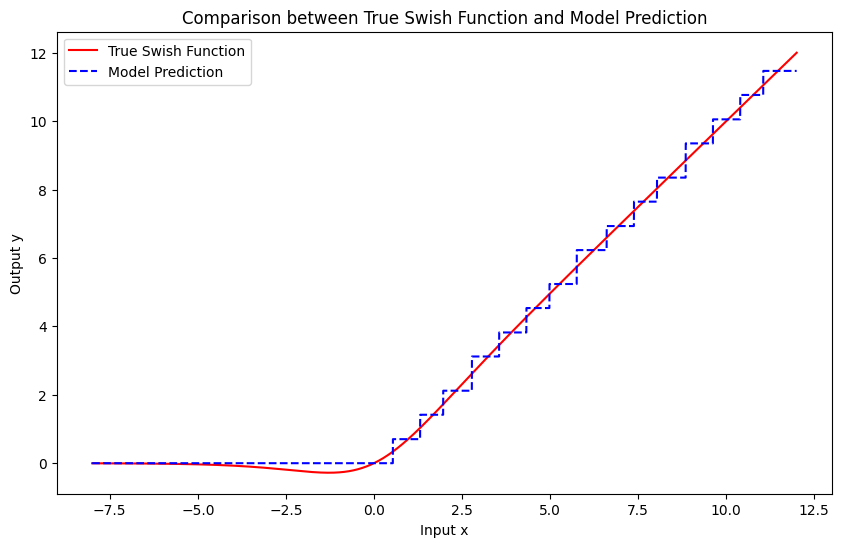

In [164]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 1.2445911169052124
Epoch 1001/20000, Loss: 0.13652636110782623
Epoch 2001/20000, Loss: 0.08179930597543716
Epoch 3001/20000, Loss: 0.06790042668581009
Epoch 4001/20000, Loss: 0.05474231392145157
Epoch 5001/20000, Loss: 0.05493471771478653
Epoch 6001/20000, Loss: 0.041776567697525024
Epoch 7001/20000, Loss: 0.02644028328359127
Epoch 8001/20000, Loss: 0.022847607731819153
Epoch 9001/20000, Loss: 0.020604662597179413
Epoch 10001/20000, Loss: 0.019941924139857292
Epoch 11001/20000, Loss: 0.019959593191742897
Epoch 12001/20000, Loss: 0.01978352852165699
Epoch 13001/20000, Loss: 0.0197087861597538
Epoch 14001/20000, Loss: 0.01957300491631031
Epoch 15001/20000, Loss: 0.019551267847418785
Epoch 16001/20000, Loss: 0.019573131576180458
Epoch 17001/20000, Loss: 0.019573358818888664
Epoch 18001/20000, Loss: 0.019574204459786415
Epoch 19001/20000, Loss: 0.019573019817471504
Loss values: [1.2445911169052124, 0.7499260902404785, 0.4418778419494629, 0.26353925466537476, 0.18113096

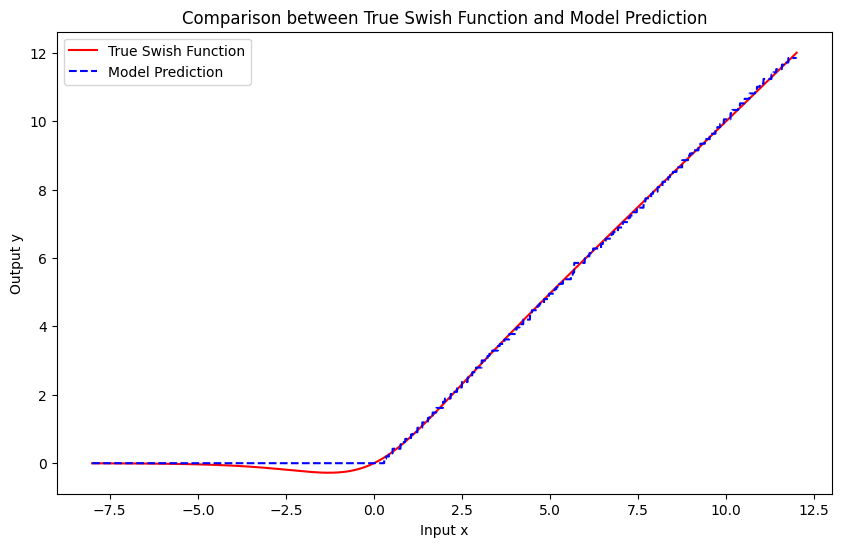

In [165]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 3.60667085647583
Epoch 1001/20000, Loss: 0.10504398494958878
Epoch 2001/20000, Loss: 0.05036648362874985
Epoch 3001/20000, Loss: 0.041492752730846405
Epoch 4001/20000, Loss: 0.03225564584136009
Epoch 5001/20000, Loss: 0.02809159830212593
Epoch 6001/20000, Loss: 0.02601545676589012
Epoch 7001/20000, Loss: 0.02387692593038082
Epoch 8001/20000, Loss: 0.02197866700589657
Epoch 9001/20000, Loss: 0.020606670528650284
Epoch 10001/20000, Loss: 0.019703876227140427
Epoch 11001/20000, Loss: 0.019124886021018028
Epoch 12001/20000, Loss: 0.01877642422914505
Epoch 13001/20000, Loss: 0.018726453185081482
Epoch 14001/20000, Loss: 0.0188683420419693
Epoch 15001/20000, Loss: 0.01888127066195011
Epoch 16001/20000, Loss: 0.018943771719932556
Epoch 17001/20000, Loss: 0.018869319930672646
Epoch 18001/20000, Loss: 0.018794341012835503
Epoch 19001/20000, Loss: 0.018772413954138756
Loss values: [3.60667085647583, 1.2359458208084106, 0.4006599187850952, 0.15076027810573578, 0.1187651976943

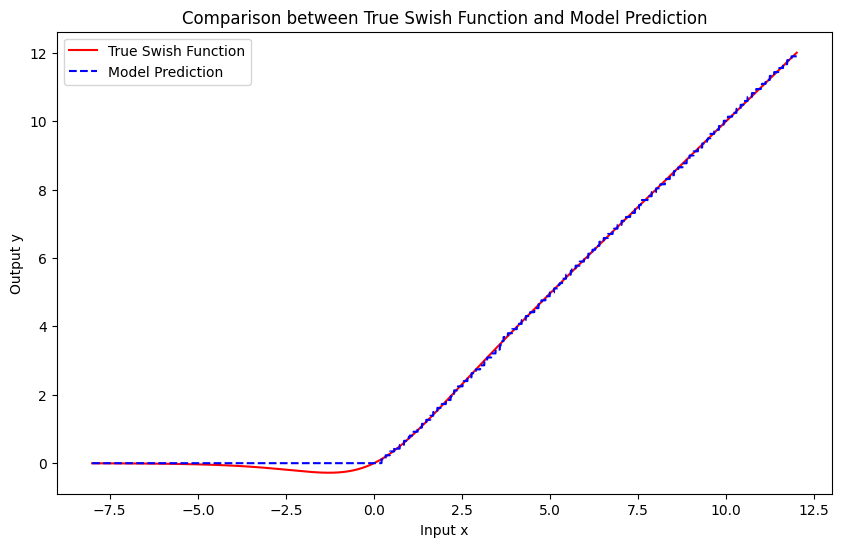

In [166]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 1.2841490507125854
Epoch 1001/20000, Loss: 0.06813132017850876
Epoch 2001/20000, Loss: 0.040409449487924576
Epoch 3001/20000, Loss: 0.022784629836678505
Epoch 4001/20000, Loss: 0.02138567715883255
Epoch 5001/20000, Loss: 0.020854923874139786
Epoch 6001/20000, Loss: 0.020718134939670563
Epoch 7001/20000, Loss: 0.020535752177238464
Epoch 8001/20000, Loss: 0.019405409693717957
Epoch 9001/20000, Loss: 0.019572788849473
Epoch 10001/20000, Loss: 0.01879865676164627
Epoch 11001/20000, Loss: 0.018463455140590668
Epoch 12001/20000, Loss: 0.01867743209004402
Epoch 13001/20000, Loss: 0.01848743110895157
Epoch 14001/20000, Loss: 0.018886197358369827
Epoch 15001/20000, Loss: 0.018481295555830002
Epoch 16001/20000, Loss: 0.018492527306079865
Epoch 17001/20000, Loss: 0.018735598772764206
Epoch 18001/20000, Loss: 0.018893752247095108
Epoch 19001/20000, Loss: 0.018742525950074196
Loss values: [1.2841490507125854, 0.2585933208465576, 0.14827539026737213, 0.10788058489561081, 0.08358

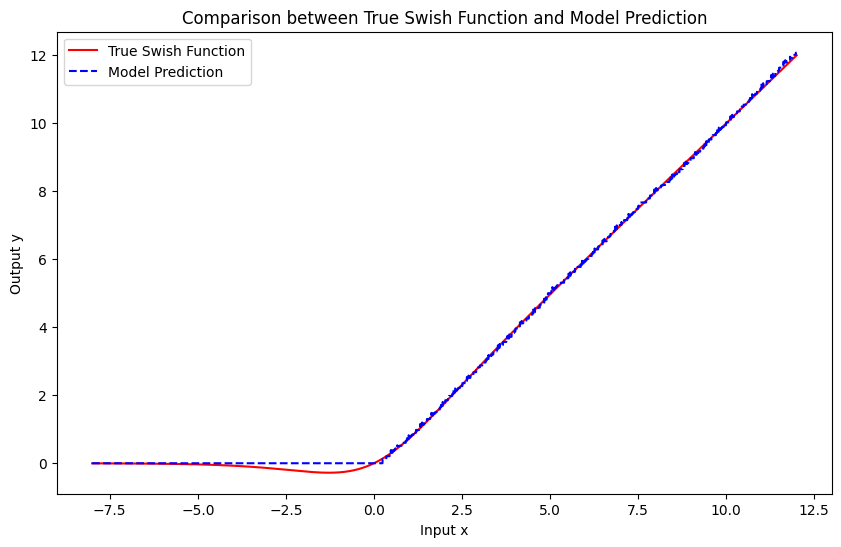

In [167]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=20

Epoch 1/20000, Loss: 6.174768924713135
Epoch 1001/20000, Loss: 0.14163078367710114
Epoch 2001/20000, Loss: 0.1115439236164093
Epoch 3001/20000, Loss: 0.04345298931002617
Epoch 4001/20000, Loss: 0.029309270903468132
Epoch 5001/20000, Loss: 0.024400288239121437
Epoch 6001/20000, Loss: 0.02229331061244011
Epoch 7001/20000, Loss: 0.021138278767466545
Epoch 8001/20000, Loss: 0.02036411315202713
Epoch 9001/20000, Loss: 0.020631011575460434
Epoch 10001/20000, Loss: 0.01990232989192009
Epoch 11001/20000, Loss: 0.019895054399967194
Epoch 12001/20000, Loss: 0.0194584671407938
Epoch 13001/20000, Loss: 0.019440382719039917
Epoch 14001/20000, Loss: 0.01896638423204422
Epoch 15001/20000, Loss: 0.01920798048377037
Epoch 16001/20000, Loss: 0.018737349659204483
Epoch 17001/20000, Loss: 0.01857147365808487
Epoch 18001/20000, Loss: 0.018516667187213898
Epoch 19001/20000, Loss: 0.018494460731744766
Loss values: [6.174768924713135, 0.8414028286933899, 0.44342100620269775, 0.25172919034957886, 0.16343754529

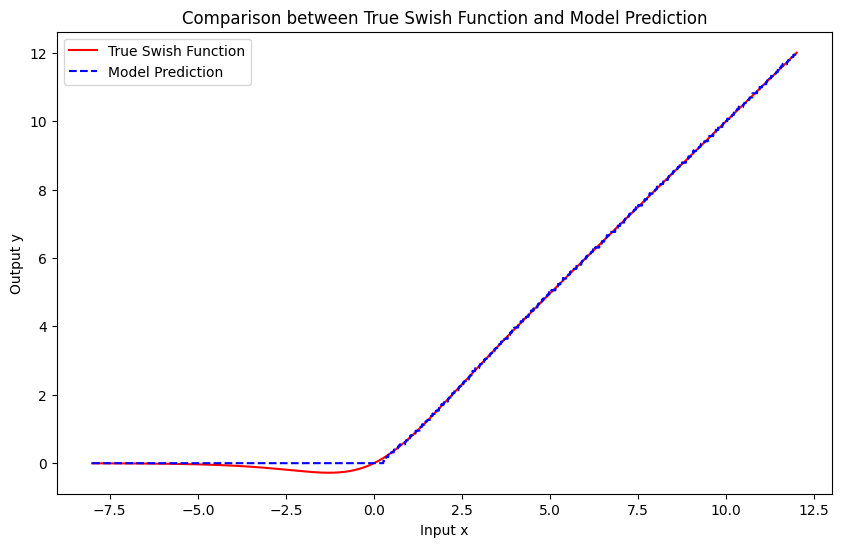

In [168]:
# Instantiate model and initial setup
num_params = 20  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=24

Epoch 1/20000, Loss: 5.821258544921875
Epoch 1001/20000, Loss: 0.11245487630367279
Epoch 2001/20000, Loss: 0.07162199169397354
Epoch 3001/20000, Loss: 0.0375882089138031
Epoch 4001/20000, Loss: 0.027898592874407768
Epoch 5001/20000, Loss: 0.023556480184197426
Epoch 6001/20000, Loss: 0.02117874287068844
Epoch 7001/20000, Loss: 0.02039589174091816
Epoch 8001/20000, Loss: 0.02002992108464241
Epoch 9001/20000, Loss: 0.019934529438614845
Epoch 10001/20000, Loss: 0.019643038511276245
Epoch 11001/20000, Loss: 0.019417403265833855
Epoch 12001/20000, Loss: 0.01921677775681019
Epoch 13001/20000, Loss: 0.019176414236426353
Epoch 14001/20000, Loss: 0.019009800627827644
Epoch 15001/20000, Loss: 0.0191250741481781
Epoch 16001/20000, Loss: 0.018773220479488373
Epoch 17001/20000, Loss: 0.01859329640865326
Epoch 18001/20000, Loss: 0.018813369795680046
Epoch 19001/20000, Loss: 0.018740493804216385
Loss values: [5.821258544921875, 0.8095102906227112, 0.2567390203475952, 0.1729850172996521, 0.133831188082

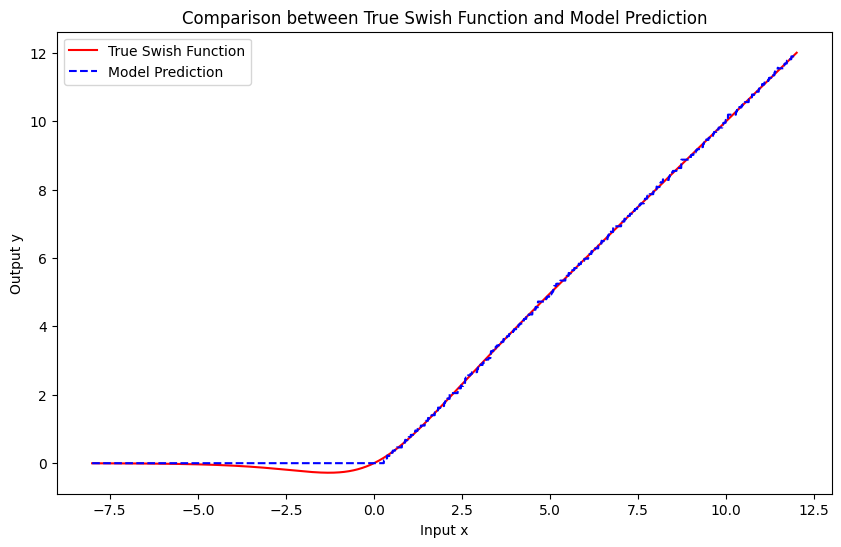

In [169]:
# Instantiate model and initial setup
num_params = 24  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

x_train = torch.cat((
    torch.linspace(-8, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 12, steps=20000)
)).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    with torch.no_grad():
        model.d.data = torch.abs(model.d.data)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/100000, Loss: 6.678145408630371
Epoch 101/100000, Loss: 2.7217469215393066
Epoch 201/100000, Loss: 1.5544687509536743
Epoch 301/100000, Loss: 1.024312138557434
Epoch 401/100000, Loss: 0.7754819393157959
Epoch 501/100000, Loss: 0.6603720188140869
Epoch 601/100000, Loss: 0.5950446724891663
Epoch 701/100000, Loss: 0.5432862639427185
Epoch 801/100000, Loss: 0.5038720369338989
Epoch 901/100000, Loss: 0.47333723306655884
Epoch 1001/100000, Loss: 0.44863632321357727
Epoch 1101/100000, Loss: 0.42804235219955444
Epoch 1201/100000, Loss: 0.41038936376571655
Epoch 1301/100000, Loss: 0.39494356513023376
Epoch 1401/100000, Loss: 0.3811963200569153
Epoch 1501/100000, Loss: 0.3687824308872223
Epoch 1601/100000, Loss: 0.35743656754493713
Epoch 1701/100000, Loss: 0.34688687324523926
Epoch 1801/100000, Loss: 0.3368939757347107
Epoch 1901/100000, Loss: 0.3272130787372589
Epoch 2001/100000, Loss: 0.3176983892917633
Epoch 2101/100000, Loss: 0.30822354555130005
Epoch 2201/100000, Loss: 0.29862016439

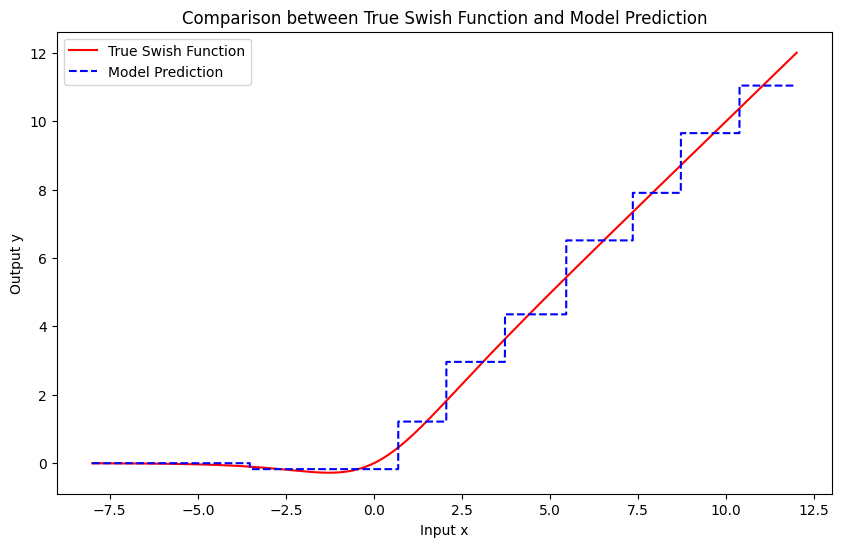

In [170]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Adjusting loss function with weights
#weights = torch.ones_like(y_train)
# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(x_train)
weights[(x_train > -5) & (x_train < 2)] = 5

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

손실 함수 가중치 적용, Adam 변경(세밀한 조정을 위해)

Epoch 1/100000, Weighted Loss: 33.045467376708984
Epoch 1001/100000, Weighted Loss: 10.680774688720703
Epoch 2001/100000, Weighted Loss: 3.434767246246338
Epoch 3001/100000, Weighted Loss: 1.4661080837249756
Epoch 4001/100000, Weighted Loss: 0.8824316263198853
Epoch 5001/100000, Weighted Loss: 0.5382153391838074
Epoch 6001/100000, Weighted Loss: 0.4039548337459564
Epoch 7001/100000, Weighted Loss: 0.35953179001808167
Epoch 8001/100000, Weighted Loss: 0.2980307638645172
Epoch 9001/100000, Weighted Loss: 0.22780059278011322
Epoch 10001/100000, Weighted Loss: 0.1960412859916687
Epoch 11001/100000, Weighted Loss: 0.17944805324077606
Epoch 12001/100000, Weighted Loss: 0.16433806717395782
Epoch 13001/100000, Weighted Loss: 0.15891768038272858
Epoch 14001/100000, Weighted Loss: 0.15888065099716187
Epoch 15001/100000, Weighted Loss: 0.15887726843357086
Epoch 16001/100000, Weighted Loss: 0.15888404846191406
Epoch 17001/100000, Weighted Loss: 0.15888792276382446
Epoch 18001/100000, Weighted Loss

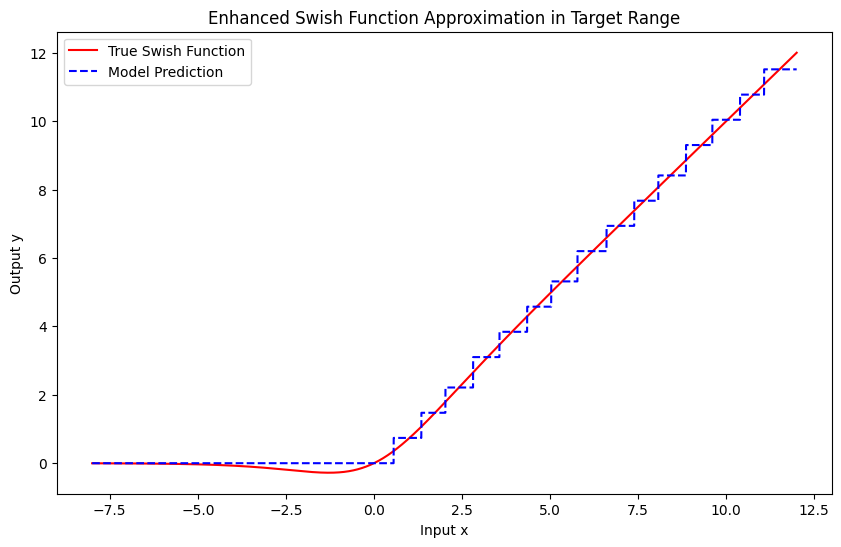

In [171]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

2트

In [172]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/100000, Weighted Loss: 30.843917846679688


Epoch 1001/100000, Weighted Loss: 11.513627052307129
Epoch 2001/100000, Weighted Loss: 3.870211601257324
Epoch 3001/100000, Weighted Loss: 1.9126479625701904
Epoch 4001/100000, Weighted Loss: 1.454108476638794
Epoch 5001/100000, Weighted Loss: 1.3036972284317017
Epoch 6001/100000, Weighted Loss: 0.9580468535423279
Epoch 7001/100000, Weighted Loss: 0.7588101029396057
Epoch 8001/100000, Weighted Loss: 0.5237321257591248
Epoch 9001/100000, Weighted Loss: 0.5401690006256104
Epoch 10001/100000, Weighted Loss: 0.18637992441654205
Epoch 11001/100000, Weighted Loss: 0.17176257073879242
Epoch 12001/100000, Weighted Loss: 0.16150958836078644
Epoch 13001/100000, Weighted Loss: 0.1589048206806183
Epoch 14001/100000, Weighted Loss: 0.15888996422290802
Epoch 15001/100000, Weighted Loss: 0.15887396037578583
Epoch 16001/100000, Weighted Loss: 0.15887713432312012
Epoch 17001/100000, Weighted Loss: 0.15888084471225739
Epoch 18001/100000, Weighted Loss: 0.15887004137039185
Epoch 19001/100000, Weighted Lo

Epoch 1/20000, Weighted Loss: 91.93415069580078
Epoch 1001/20000, Weighted Loss: 28.841529846191406
Epoch 2001/20000, Weighted Loss: 9.464917182922363
Epoch 3001/20000, Weighted Loss: 3.7767374515533447
Epoch 4001/20000, Weighted Loss: 2.2520182132720947
Epoch 5001/20000, Weighted Loss: 1.7696940898895264
Epoch 6001/20000, Weighted Loss: 1.2178773880004883
Epoch 7001/20000, Weighted Loss: 0.7043254971504211
Epoch 8001/20000, Weighted Loss: 0.5405889749526978
Epoch 9001/20000, Weighted Loss: 0.47573551535606384
Epoch 10001/20000, Weighted Loss: 0.33974218368530273
Epoch 11001/20000, Weighted Loss: 0.29945409297943115
Epoch 12001/20000, Weighted Loss: 0.27452585101127625
Epoch 13001/20000, Weighted Loss: 0.25079140067100525
Epoch 14001/20000, Weighted Loss: 0.21247152984142303
Epoch 15001/20000, Weighted Loss: 0.19390961527824402
Epoch 16001/20000, Weighted Loss: 0.19384656846523285
Epoch 17001/20000, Weighted Loss: 0.19384269416332245
Epoch 18001/20000, Weighted Loss: 0.1938451975584030

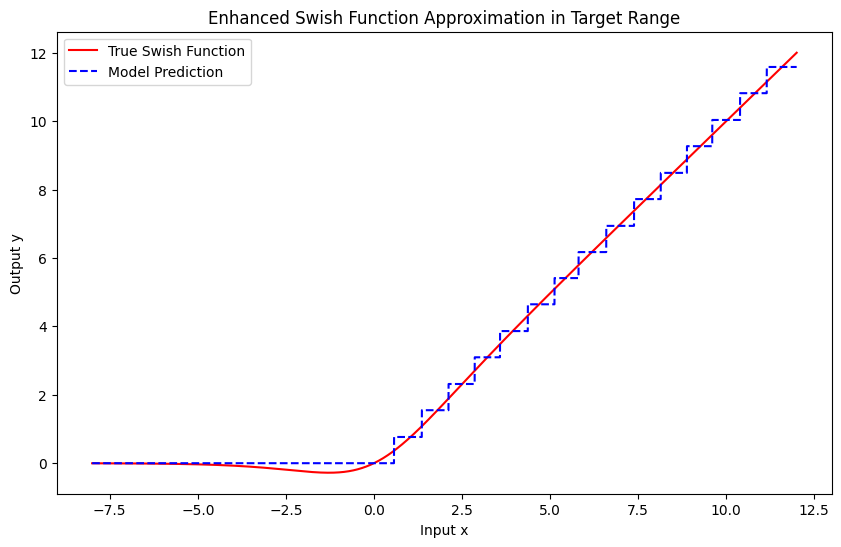

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.linspace(-8, 12, 100000).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 20000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

타임스텝을 8로 했을 때 실험

Epoch 1/30000, Weighted Loss: 16.61417579650879
Epoch 1001/30000, Weighted Loss: 1.2757399082183838
Epoch 2001/30000, Weighted Loss: 0.5546097755432129
Epoch 3001/30000, Weighted Loss: 0.2816918194293976
Epoch 4001/30000, Weighted Loss: 0.2259213924407959
Epoch 5001/30000, Weighted Loss: 0.13338996469974518
Epoch 6001/30000, Weighted Loss: 0.10963110625743866
Epoch 7001/30000, Weighted Loss: 0.09253785014152527
Epoch 8001/30000, Weighted Loss: 0.06837064772844315
Epoch 9001/30000, Weighted Loss: 0.04454335570335388
Epoch 10001/30000, Weighted Loss: 0.027929745614528656
Epoch 11001/30000, Weighted Loss: 0.02747015468776226
Epoch 12001/30000, Weighted Loss: 0.02269786410033703
Epoch 13001/30000, Weighted Loss: 0.020288918167352676
Epoch 14001/30000, Weighted Loss: 0.01870781183242798
Epoch 15001/30000, Weighted Loss: 0.018342275172472
Epoch 16001/30000, Weighted Loss: 0.018668411299586296
Epoch 17001/30000, Weighted Loss: 0.018388522788882256
Epoch 18001/30000, Weighted Loss: 0.018386254

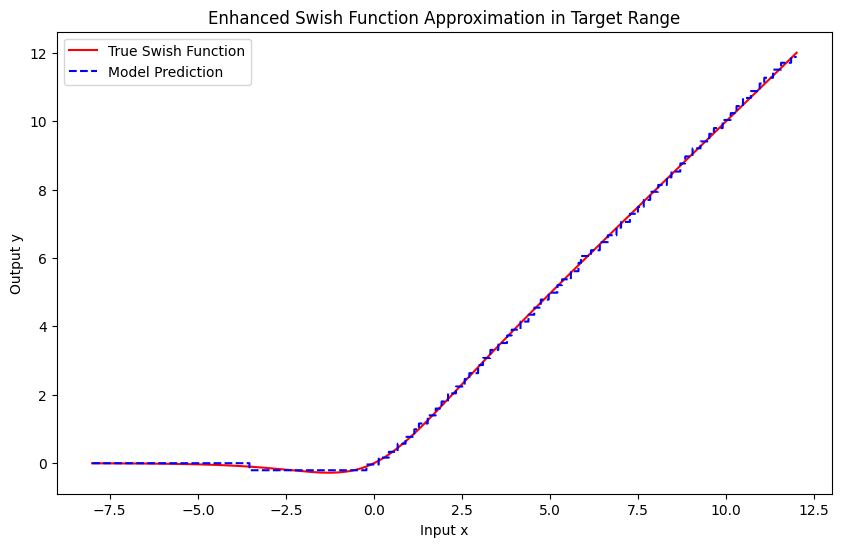

In [ ]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 30000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

똑같이 만든 코드

Epoch 1/100000, Loss: 19.068017959594727
Epoch 101/100000, Loss: 16.951717376708984
Epoch 201/100000, Loss: 15.039765357971191
Epoch 301/100000, Loss: 13.334458351135254
Epoch 401/100000, Loss: 11.834134101867676
Epoch 501/100000, Loss: 10.527331352233887
Epoch 601/100000, Loss: 9.391438484191895
Epoch 701/100000, Loss: 8.399218559265137
Epoch 801/100000, Loss: 7.521166801452637
Epoch 901/100000, Loss: 6.738089561462402
Epoch 1001/100000, Loss: 6.037535190582275
Epoch 1101/100000, Loss: 5.410695552825928
Epoch 1201/100000, Loss: 4.851280212402344
Epoch 1301/100000, Loss: 4.35178279876709
Epoch 1401/100000, Loss: 3.906303644180298
Epoch 1501/100000, Loss: 3.508561849594116
Epoch 1601/100000, Loss: 3.1537232398986816
Epoch 1701/100000, Loss: 2.8386828899383545
Epoch 1801/100000, Loss: 2.5663888454437256
Epoch 1901/100000, Loss: 2.3151230812072754
Epoch 2001/100000, Loss: 2.082207679748535
Epoch 2101/100000, Loss: 1.8740965127944946
Epoch 2201/100000, Loss: 1.6984962224960327
Epoch 2301/1

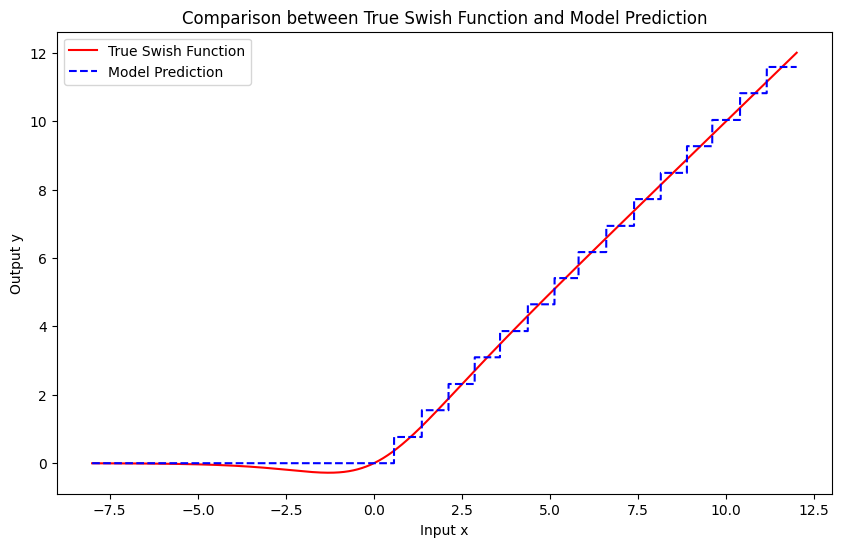

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

GeLU

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 16  # Select arbitrary number of neurons
num_params = 16  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = gelu(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = gelu(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True GeLU Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True GeLU Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

TypeError: FS.__init__() takes 2 positional arguments but 4 were given

Epoch 1/100000, Loss: 16.04350471496582
Epoch 1001/100000, Loss: 0.03995278477668762
Epoch 2001/100000, Loss: 0.01932363584637642
Epoch 3001/100000, Loss: 0.016070056706666946
Epoch 4001/100000, Loss: 0.01664649322628975
Epoch 5001/100000, Loss: 0.013625516556203365
Epoch 6001/100000, Loss: 0.012381268665194511
Epoch 7001/100000, Loss: 0.011113815009593964
Epoch 8001/100000, Loss: 0.010645362548530102
Epoch 9001/100000, Loss: 0.013937012292444706
Epoch 10001/100000, Loss: 0.0089075593277812
Epoch 11001/100000, Loss: 0.010526244528591633
Epoch 12001/100000, Loss: 0.009391916915774345
Epoch 13001/100000, Loss: 0.010111148469150066
Epoch 14001/100000, Loss: 0.008871813304722309
Epoch 15001/100000, Loss: 0.009034411981701851
Epoch 16001/100000, Loss: 0.008882645517587662
Epoch 17001/100000, Loss: 0.009219828061759472
Epoch 18001/100000, Loss: 0.008641485124826431
Epoch 19001/100000, Loss: 0.010022853501141071
Epoch 20001/100000, Loss: 0.006460567004978657
Epoch 21001/100000, Loss: 0.005467

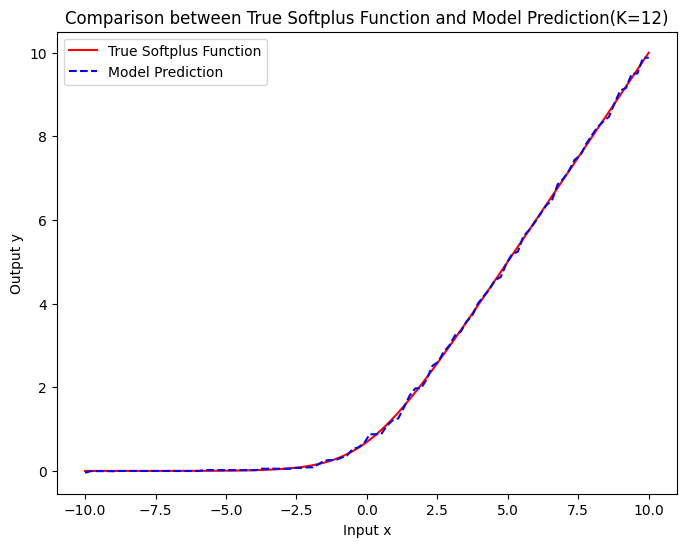

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 12  # Select arbitrary number of neurons
num_params = 12  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

loss_values = []

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

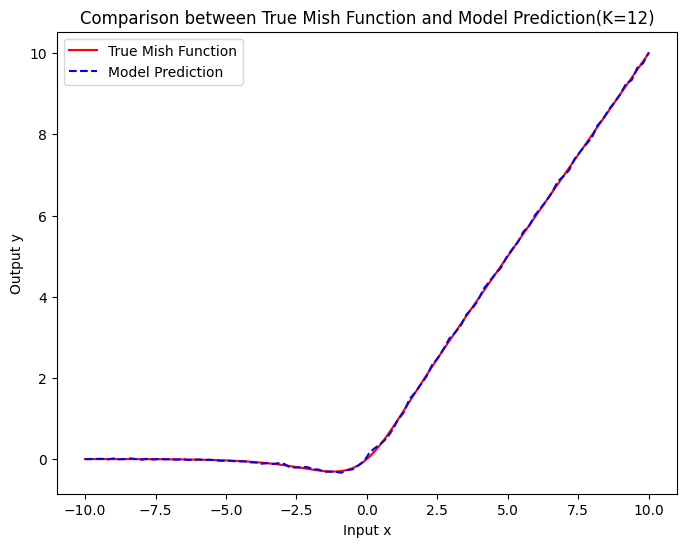

In [ ]:
# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = mish(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Mish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Mish Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()